In [1]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [2]:
# Configuration
DATA_ROOT = Path(".")
IMAGES_DIRS = [
    DATA_ROOT / "HAM10000_images_part_1",
    DATA_ROOT / "HAM10000_images_part_2",
]
META_CSV = DATA_ROOT / "HAM10000_metadata.csv"
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / "skin_cancer_cnn.pth"

# Hyperparameters - optimized for faster training
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 20  # Increased to 20 epochs with less aggressive early stopping
LR = 1e-4
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
SEED = 42

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("="*60)
print("SKIN CANCER DETECTION MODEL - OPTIMIZED VERSION")
print("="*60)
print(f"\nDevice: {DEVICE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Learning rate: {LR}")
print(f"\nData paths:")
print(f"  Metadata: {META_CSV.resolve()}")
for img_dir in IMAGES_DIRS:
    exists = img_dir.exists()
    print(f"  Images: {img_dir.resolve()} {'✓' if exists else '✗'}")
print("="*60)


SKIN CANCER DETECTION MODEL - OPTIMIZED VERSION

Device: cuda
Batch size: 32
Image size: 224x224
Learning rate: 0.0001

Data paths:
  Metadata: C:\Users\youssef desoky\Desktop\program challenge\HAM10000_metadata.csv
  Images: C:\Users\youssef desoky\Desktop\program challenge\HAM10000_images_part_1 ✓
  Images: C:\Users\youssef desoky\Desktop\program challenge\HAM10000_images_part_2 ✓


In [3]:
assert META_CSV.exists(), f"Metadata CSV not found at {META_CSV}."
meta = pd.read_csv(META_CSV)
print("Metadata loaded successfully!")
print(f"Total rows: {len(meta)}")
print("\nDiagnosis distribution:")
print(meta['dx'].value_counts())
print("\nFirst few rows:")
print(meta.head())


def map_dx_to_binary(dx: str) -> int:
    """Map diagnosis to binary: 1 = cancer (mel, bcc, akiec), 0 = non-cancer"""
    cancer_labels = {"mel", "bcc", "akiec"}
    return 1 if dx in cancer_labels else 0


def resolve_image_path(image_id: str) -> Path:
    """Find image file in either directory"""
    filename = f"{image_id}.jpg"
    for img_dir in IMAGES_DIRS:
        candidate = img_dir / filename
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f"Image not found: {image_id}.jpg")


# Create target labels
meta["target"] = meta["dx"].apply(map_dx_to_binary)
print(f"\nTarget distribution:")
print(meta["target"].value_counts())
print(f"Cancer: {meta['target'].sum()}, Non-cancer: {(meta['target']==0).sum()}")

# Resolve image paths
print("\nResolving image paths...")
meta["image_path"] = meta["image_id"].apply(resolve_image_path)

# Verify all images exist
missing = meta[~meta["image_path"].apply(lambda p: p.exists())]
if len(missing) > 0:
    print(f"WARNING: {len(missing)} images not found!")
    print(missing.head())
else:
    print(f"✓ All {len(meta)} images found!")

# Verify we can actually load an image
print("\nTesting image loading...")
test_img_path = meta.iloc[0]["image_path"]
test_img = Image.open(test_img_path).convert("RGB")
print(f"✓ Successfully loaded test image: {test_img_path.name}")
print(f"  Image size: {test_img.size}, Mode: {test_img.mode}")


Metadata loaded successfully!
Total rows: 10015

Diagnosis distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

First few rows:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Target distribution:
target
0    8061
1    1954
Name: count, dtype: int64
Cancer: 1954, Non-cancer: 8061

Resolving image paths...
✓ All 10015 images found!

Testing image loading...
✓ Successfully loaded test image: ISIC_0027419.jpg
  Image size: (600, 450), Mode: RGB


In [4]:
# Train/val/test split
from sklearn.model_selection import train_test_split

indices = np.arange(len(meta))
train_idx, temp_idx = train_test_split(
    indices, test_size=VAL_SPLIT + TEST_SPLIT, random_state=SEED, stratify=meta["target"]
)
val_rel = VAL_SPLIT / (VAL_SPLIT + TEST_SPLIT)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=1 - val_rel, random_state=SEED, stratify=meta.loc[temp_idx, "target"]
)

print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}, Test size: {len(test_idx)}")

meta_train = meta.iloc[train_idx].reset_index(drop=True)
meta_val = meta.iloc[val_idx].reset_index(drop=True)
meta_test = meta.iloc[test_idx].reset_index(drop=True)


Train size: 7010, Val size: 1502, Test size: 1503


Creating datasets...
Creating data loaders...
✓ Datasets created: Train=7010, Val=1502, Test=1503

Testing data loader...
✓ Batch loaded: images shape=torch.Size([32, 3, 224, 224]), labels shape=torch.Size([32])
  Label distribution in batch: 3/32 cancer

VERIFYING DATA AUGMENTATION (especially flips)
Loading a sample image and showing augmented versions...


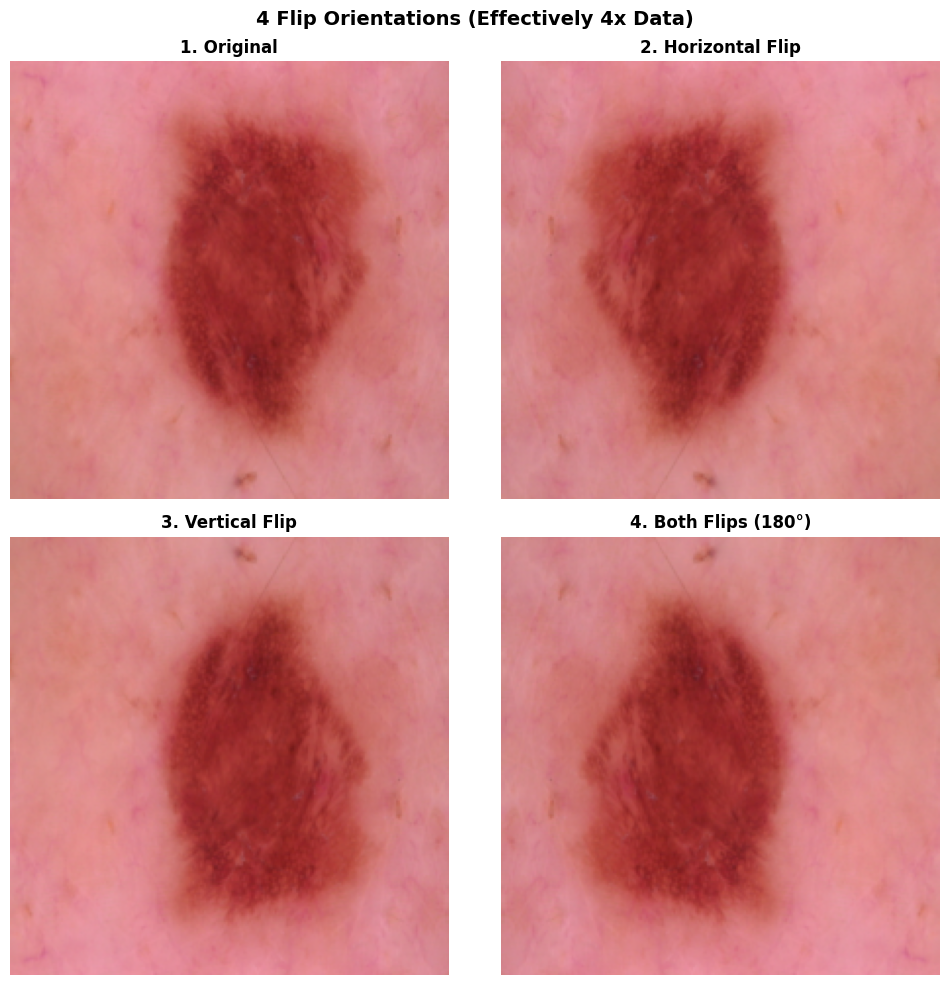


Random augmented examples (with all transformations):


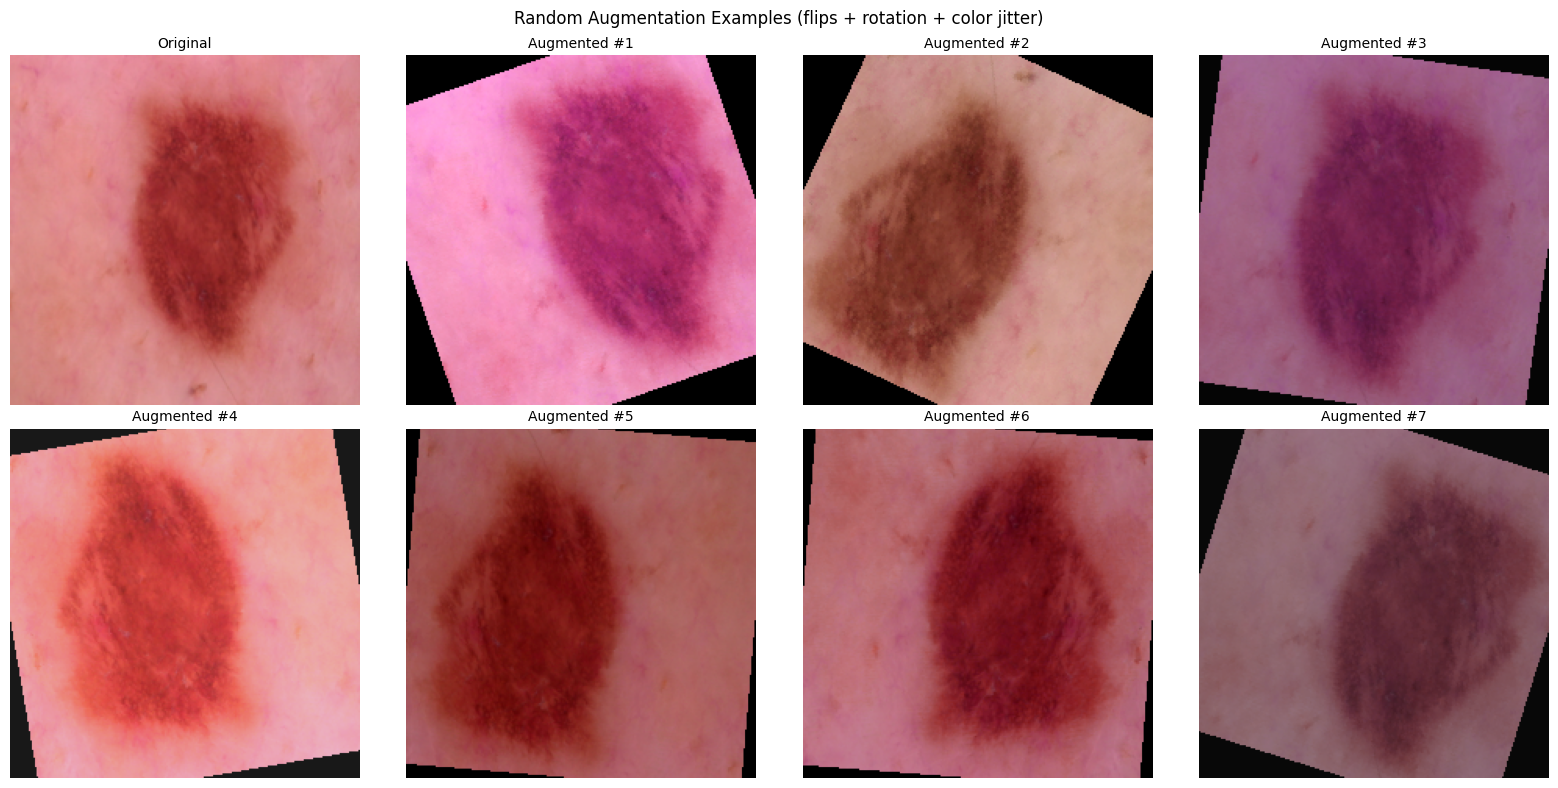

✓ Augmentation verified!
  ✓ Horizontal flips: YES (50% probability)
  ✓ Vertical flips: YES (50% probability)
  ✓ Combined: Each image can appear in 4 orientations = 4x effective data
  ✓ Additional: Rotation (±30°), Color jitter, Random crop, etc.


In [5]:
class SkinCancerDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label = int(row["target"])

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0, 0, 0))
            if self.transform:
                image = self.transform(image)

        return image, label

# Enhanced data augmentation for training - optimized for medical imaging
# Key: Horizontal + Vertical flips effectively quadruple the data (4 orientations)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),  # Slightly larger for random crop
    transforms.RandomCrop(IMG_SIZE),
    # CRITICAL: Both flips - in medical imaging, orientation doesn't matter
    # This gives us 4x data: original, H-flip, V-flip, both flips (180°)
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance horizontal flip
    transforms.RandomVerticalFlip(p=0.5),   # 50% chance vertical flip
    transforms.RandomRotation(30),  # Rotation up to 30° (moles look same rotated)
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Lighting variations
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Position/scale variations
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.2),  # Focus variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33)),  # Occlusion robustness
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Creating datasets...")
train_ds = SkinCancerDataset(meta_train, transform=train_transform)
val_ds = SkinCancerDataset(meta_val, transform=val_test_transform)
test_ds = SkinCancerDataset(meta_test, transform=val_test_transform)

print("Creating data loaders...")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

print(f"✓ Datasets created: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")

print("\nTesting data loader...")
sample_batch = next(iter(train_loader))
images, labels = sample_batch
print(f"✓ Batch loaded: images shape={images.shape}, labels shape={labels.shape}")
print(f"  Label distribution in batch: {labels.sum().item()}/{len(labels)} cancer")

print("\n" + "="*60)
print("VERIFYING DATA AUGMENTATION (especially flips)")
print("="*60)
print("Loading a sample image and showing augmented versions...")

sample_idx = 0
sample_row = meta_train.iloc[sample_idx]
sample_img_path = sample_row["image_path"]
original_img = Image.open(sample_img_path).convert("RGB")
original_img_resized = transforms.Resize((IMG_SIZE, IMG_SIZE))(original_img)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("4 Flip Orientations (Effectively 4x Data)", fontsize=14, fontweight='bold')

axes[0, 0].imshow(original_img_resized)
axes[0, 0].set_title("1. Original", fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

h_flip = transforms.RandomHorizontalFlip(p=1.0)(original_img_resized)
axes[0, 1].imshow(h_flip)
axes[0, 1].set_title("2. Horizontal Flip", fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

v_flip = transforms.RandomVerticalFlip(p=1.0)(original_img_resized)
axes[1, 0].imshow(v_flip)
axes[1, 0].set_title("3. Vertical Flip", fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

both_flips = transforms.RandomVerticalFlip(p=1.0)(transforms.RandomHorizontalFlip(p=1.0)(original_img_resized))
axes[1, 1].imshow(both_flips)
axes[1, 1].set_title("4. Both Flips (180°)", fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Show random augmented versions
print("\nRandom augmented examples (with all transformations):")
fig2, axes2 = plt.subplots(2, 4, figsize=(16, 8))
axes2[0, 0].imshow(original_img_resized)
axes2[0, 0].set_title("Original", fontsize=10)
axes2[0, 0].axis('off')

viz_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
])

for i in range(7):
    row = (i + 1) // 4
    col = (i + 1) % 4
    aug_img = viz_transform(original_img)
    axes2[row, col].imshow(aug_img)
    axes2[row, col].set_title(f"Augmented #{i+1}", fontsize=10)
    axes2[row, col].axis('off')

plt.suptitle("Random Augmentation Examples (flips + rotation + color jitter)", fontsize=12)
plt.tight_layout()
plt.show()

print("✓ Augmentation verified!")
print("  ✓ Horizontal flips: YES (50% probability)")
print("  ✓ Vertical flips: YES (50% probability)")
print("  ✓ Combined: Each image can appear in 4 orientations = 4x effective data")
print("  ✓ Additional: Rotation (±30°), Color jitter, Random crop, etc.")
print("="*60)


In [6]:
# Use MobileNetV2 - lighter and faster than ResNet18
print("Loading MobileNetV2 (pre-trained on ImageNet)...")
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
for param in base_model.features[:-3].parameters():
    param.requires_grad = False

base_model.classifier = nn.Sequential(
    nn.Dropout(0.4),  # Main dropout layer
    nn.Linear(base_model.last_channel, 128),  # Add intermediate layer
    nn.ReLU(),
    nn.Dropout(0.3),  # Additional dropout layer
    nn.Linear(128, 1)
)

model = base_model.to(DEVICE)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model created: {trainable_params:,} trainable / {total_params:,} total parameters")
print(f"  Dropout: 0.4 (main), 0.3 (intermediate)")

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=5e-4)  # Increased from 1e-4 to 5e-4

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=1e-6
)

print(f"✓ Optimizer: Adam (lr={LR}, weight_decay=5e-4)")
print(f"✓ Scheduler: ReduceLROnPlateau (factor=0.5, patience=2, monitors val_loss)")
print(f"✓ Anti-overfitting measures: Dropout (0.4), Weight decay (5e-4), Enhanced augmentation")


Loading MobileNetV2 (pre-trained on ImageNet)...
✓ Model created: 1,370,177 trainable / 2,387,969 total parameters
  Dropout: 0.4 (main), 0.3 (intermediate)
✓ Optimizer: Adam (lr=0.0001, weight_decay=5e-4)
✓ Scheduler: ReduceLROnPlateau (factor=0.5, patience=2, monitors val_loss)
✓ Anti-overfitting measures: Dropout (0.4), Weight decay (5e-4), Enhanced augmentation


c:\Users\youssef desoky\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
# Training & validation loops with progress tracking

def train_one_epoch(model, loader, optimizer, criterion, device=DEVICE):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()
        correct += (preds.cpu().squeeze() == labels.cpu().squeeze().long()).sum().item()
        total += labels.size(0)
        
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch {batch_idx+1}/{len(loader)}, Loss: {loss.item():.4f}, Acc: {correct/total:.4f}")

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device=DEVICE):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()
            correct += (preds.cpu().squeeze() == labels.cpu().squeeze().long()).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy().flatten().tolist())
            all_probs.extend(probs.cpu().numpy().flatten().tolist())

    return running_loss / total, correct / total, np.array(all_labels), np.array(all_probs)


In [8]:
import time

best_val_acc = 0.0
best_val_loss = float('inf')
patience = 5  
patience_counter = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

print(f"\n{'='*60}")
print(f"Starting training for {EPOCHS} epochs (early stopping patience={patience})")
print(f"Configuration: Dropout=0.4, Weight decay=5e-4, LR scheduler enabled")
print(f"{'='*60}\n")

start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()
    
    print(f"Epoch {epoch}/{EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start
    
    improved = False
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        patience_counter = 0
        improved = True
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  ✓ New best model saved! (val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f})")
    elif val_acc == best_val_acc and val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        improved = True
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  ✓ Model updated (same acc, lower loss: {val_loss:.4f})")
    else:
        patience_counter += 1

    overfit_warning = ""
    if len(history["train_acc"]) > 1:
        train_val_gap = train_acc - val_acc
        if train_val_gap > 0.15:  # More than 15% gap indicates overfitting
            overfit_warning = f" ⚠️ Overfitting gap: {train_val_gap:.2%}"
    
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"Val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"LR: {current_lr:.2e} | Time: {epoch_time:.1f}s{overfit_warning}")
    print()

    if patience_counter >= patience:
        print(f"Early stopping triggered (no improvement for {patience} epochs)")
        print(f"Best validation accuracy: {best_val_acc:.4f} (saved model from epoch {len(history['val_acc']) - patience})")
        break

total_time = time.time() - start_time
print(f"{'='*60}")
print(f"Training completed in {total_time/60:.1f} minutes")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"{'='*60}")



Starting training for 20 epochs (early stopping patience=5)
Configuration: Dropout=0.4, Weight decay=5e-4, LR scheduler enabled

Epoch 1/20
  Batch 100/220, Loss: 0.6915, Acc: 0.8100
  Batch 200/220, Loss: 0.5322, Acc: 0.8209
  ✓ New best model saved! (val_acc: 0.8509, val_loss: 0.3406)
  Train: loss=0.3801, acc=0.8215 | Val: loss=0.3406, acc=0.8509 | LR: 1.00e-04 | Time: 111.3s

Epoch 2/20
  Batch 100/220, Loss: 0.4542, Acc: 0.8363
  Batch 200/220, Loss: 0.2049, Acc: 0.8378
  Train: loss=0.3375, acc=0.8391 | Val: loss=0.3615, acc=0.8422 | LR: 1.00e-04 | Time: 118.4s

Epoch 3/20
  Batch 100/220, Loss: 0.2751, Acc: 0.8406
  Batch 200/220, Loss: 0.2417, Acc: 0.8445
  Train: loss=0.3326, acc=0.8451 | Val: loss=0.3343, acc=0.8469 | LR: 1.00e-04 | Time: 120.0s

Epoch 4/20
  Batch 100/220, Loss: 0.2536, Acc: 0.8488
  Batch 200/220, Loss: 0.2902, Acc: 0.8508
  ✓ Model updated (same acc, lower loss: 0.3244)
  Train: loss=0.3262, acc=0.8505 | Val: loss=0.3244, acc=0.8509 | LR: 1.00e-04 | Time:

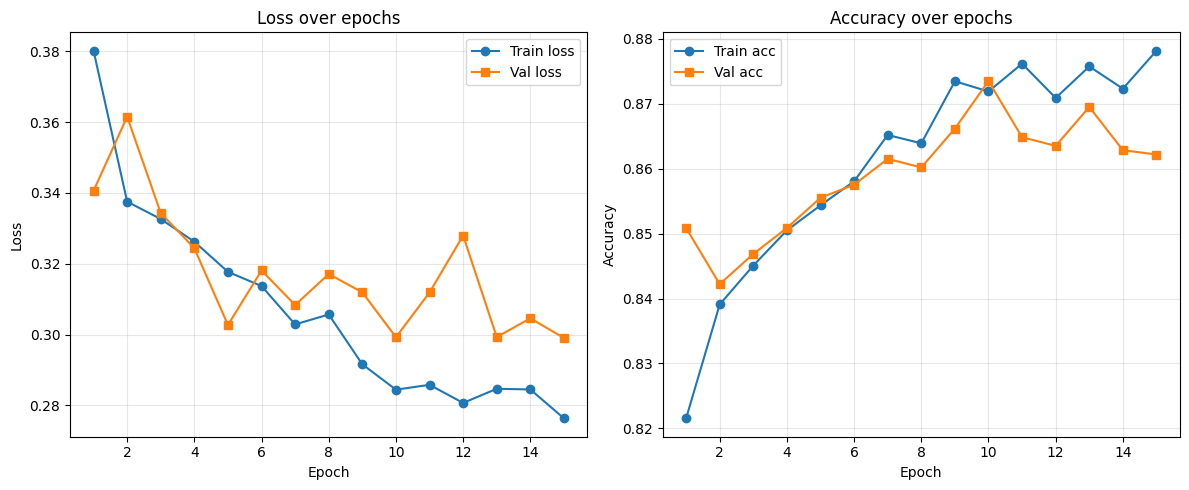

In [9]:
num_epochs_trained = len(history["train_loss"])
epochs_range = range(1, num_epochs_trained + 1)

if num_epochs_trained > 0:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train loss", marker='o')
    plt.plot(epochs_range, history["val_loss"], label="Val loss", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over epochs")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history["train_acc"], label="Train acc", marker='o')
    plt.plot(epochs_range, history["val_acc"], label="Val acc", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy over epochs")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No training history available. Please run the training cell first.")


C:\Users\youssef desoky\AppData\Local\Temp\ipykernel_30384\3545094344.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_lo

Test loss: 0.3043, Test acc: 0.8663
Classification report (0 = non-cancer, 1 = cancer):
              precision    recall  f1-score   support

         0.0     0.8866    0.9562    0.9201      1210
         1.0     0.7323    0.4949    0.5906       293

    accuracy                         0.8663      1503
   macro avg     0.8095    0.7255    0.7554      1503
weighted avg     0.8565    0.8663    0.8559      1503



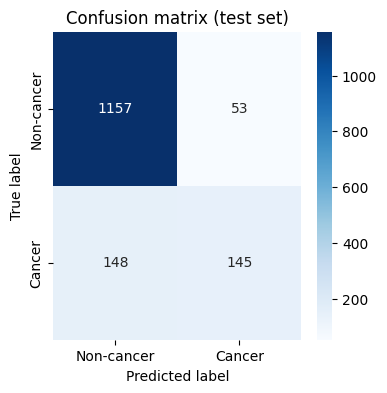

In [10]:
# Load best model and evaluate on test set

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)

test_loss, test_acc, y_true, y_prob = evaluate(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

y_pred = (y_prob >= 0.5).astype(int)

print("Classification report (0 = non-cancer, 1 = cancer):")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-cancer", "Cancer"], yticklabels=["Non-cancer", "Cancer"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion matrix (test set)")
plt.show()
